# Multiclass Classification & Bounding Box Regression | Caltech101
Hi everyone! In this my new notebook we're going to learn how to predict coordinates and classes of objects with given images coords in dataset, using VGG16 (CNN) by Tensorflow. For this task we'll use regression for vector with coords prediction and classification to predict the class of the object.

### 🥰 Acknowledgements
[Multi-class object detection and bounding box regression with Keras, TensorFlow, and Deep Learning](https://pyimagesearch.com/2020/10/12/multi-class-object-detection-and-bounding-box-regression-with-keras-tensorflow-and-deep-learning/)

# 📚 Libraries
Firslty, we need to import custom library *imutils* by Adrian Rosebrock. It will be imported from folders that were loaded by be to Kaggle:

In [1]:
!pip3 install imutils

  Preparing metadata (setup.py) ... - done
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25858 sha256=952c7bc5479995f8846bcc023edcccf0b661a8d220a285206c613ba5f71172ac
  Stored in directory: /root/.cache/pip/wheels/86/d7/0a/4923351ed1cec5d5e24c1eaf8905567b02a0343b24aa873df2
Successfully built imutils


In [2]:
from imutils import paths
import os
import cv2
import imageio as iio
import datetime
import numpy as np

import time

import pandas as pd

from tqdm import tqdm

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.model_selection import train_test_split

import torch.nn as nn
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
import torch.nn.functional as F
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer

import torch
import torchvision
from torchvision.io import read_image
from torchvision.utils import draw_bounding_boxes
from torch.utils.data import Dataset, DataLoader
from torchvision import models,transforms

import pickle

In [3]:
class My_Dataset(Dataset):
  def __init__(self, path, width, heigth, trans = None):
    self.path = path
    self.df = pd.read_csv(f'{path}train.csv')
    self.trans = trans
    self.width = width
    self.heigth = heigth


  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
#     im = iio.imread(f"{self.path}/images/{self.df.iloc[idx,1]}")
    im = iio.v2.imread(f"{self.path}/images/{self.df.iloc[idx,1]}")

    # print(im.shape)
    
    # Class & Label Dictionary
    classNameDict = dict(zip(self.df['class'].unique().tolist(), self.df['name'].unique().tolist()))
    
    self.df['class'] = self.df['class']#.astype('int32')
    
    img_class = self.df.iloc[idx,0]
    label = self.df.iloc[idx,2]
    
    xmax = self.df.iloc[idx,3]*2 / self.width
    xmin = self.df.iloc[idx,4]*2 / self.width
    ymax = self.df.iloc[idx,5]*2 / self.heigth
    ymin = self.df.iloc[idx,6]*2 / self.heigth
    
    # bbox = np.array([xmax, xmin, ymax, ymin])
    
    if self.trans:
      im = self.trans(im)

    return (im, img_class, xmax.astype(float), xmin.astype(float), ymax.astype(float), ymin.astype(float), label, classNameDict)

In [4]:
WIDTH = 1920
HEIGHT = 1080

In [5]:
dataset = My_Dataset("/kaggle/input/smartathondataset/dataset/" , WIDTH, HEIGHT, transforms.ToTensor())

# dataset[0][0]

In [6]:
batch_size = 16
train_loader = DataLoader(dataset, batch_size = batch_size, shuffle = True)

In [7]:
tl = iter(train_loader)
batch = next(tl)
batch[0].shape

torch.Size([16, 3, 1080, 1920])

In [8]:
xmax = batch[2] * WIDTH
xmin = batch[3] * WIDTH

ymax = batch[4] * HEIGHT
ymin = batch[5] * HEIGHT

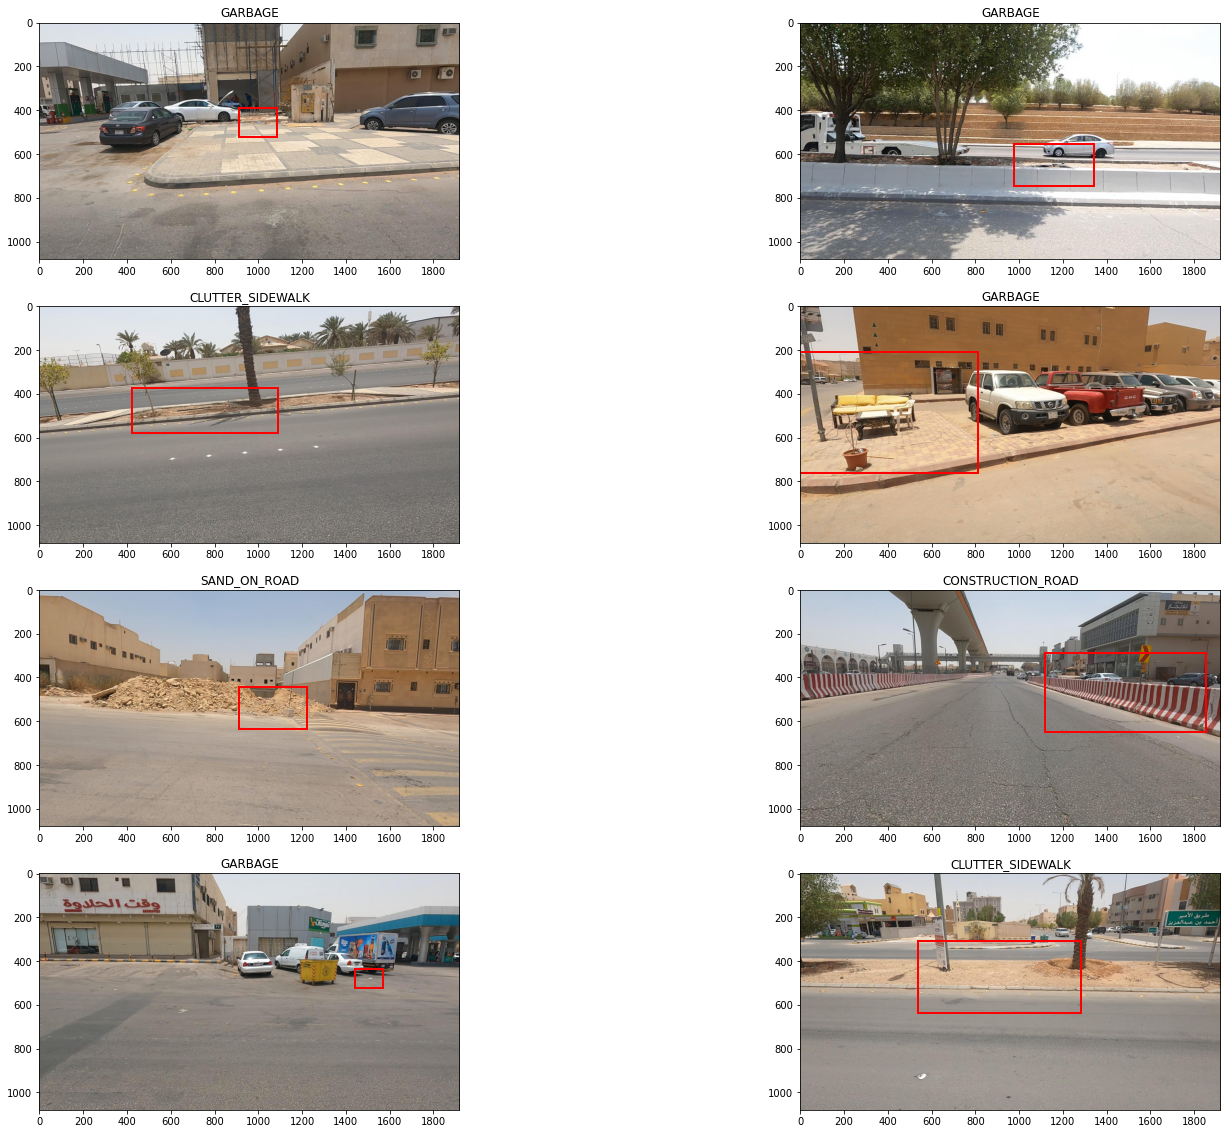

In [9]:
k = 1
plt.figure(figsize=(25,20))
for i in range(8):
    plt.subplot(4,2,k)
    img = batch[0][k-1,:,:,:]
    plt.gca().add_patch(Rectangle((xmin[k-1],ymin[k-1]),xmax[k-1]-xmin[k-1],ymax[k-1]-ymin[k-1],
                    edgecolor='red',
                    facecolor='none',
                    lw=2))
    plt.xticks(np.arange(0, 1920, 200))
    plt.imshow(np.transpose(img, (1,2,0)))
    plt.title(batch[6][k-1])
    k+=1

In [10]:
class ObjectDetector(nn.Module):
	def __init__(self, baseModel, numClasses):
		super(ObjectDetector, self).__init__()
		# initialize the base model and the number of classes
		self.baseModel = baseModel
		self.numClasses = numClasses
		# build the regressor head for outputting the bounding box
		# coordinates
		self.regressor = nn.Sequential(
			nn.Linear(baseModel.fc.in_features, 512),
			nn.ReLU(),
			nn.Linear(512, 128),
			nn.ReLU(),
			nn.Linear(128, 32),
			nn.ReLU(),
			nn.Linear(32, 4),
			nn.Sigmoid()
		)
		# build the classifier head to predict the class labels
		self.classifier = nn.Sequential(
			nn.Linear(baseModel.fc.in_features, 512),
			nn.ReLU(),
			nn.Dropout(),
			nn.Linear(512, 128),
			nn.ReLU(),
			nn.Dropout(),
			nn.Linear(128, self.numClasses)
		)
		# set the classifier of our base model to produce outputs
		# from the last convolution block
		self.baseModel.fc = nn.Identity()

	def forward(self, x):
		# pass the inputs through the base model and then obtain
		# predictions from two different branches of the network
		features = self.baseModel(x)
		bboxes = self.regressor(features)
		# print(bboxes.shape)
		xmax, xmin, ymax, ymin = bboxes.view(4,-1)
		classLogits = self.classifier(features)
		# return the outputs as a tuple
		return (xmax.type(torch.FloatTensor), xmin.type(torch.FloatTensor), ymax.type(torch.FloatTensor), ymin.type(torch.FloatTensor), classLogits)

In [11]:
# load the ResNet50 network
model = models.resnet50(pretrained=True)

# freeze all ResNet50 layers so they will *not* be updated during the
# training process
for param in model.parameters():
	param.requires_grad = False

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [12]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [13]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
NUM_CLASSES = 11

model = model.to(device)

objectDetector = ObjectDetector(model, NUM_CLASSES)
objectDetector = objectDetector.to(device)

In [14]:
device

'cuda:0'

In [15]:
def bboxLossFunc(preds, actual):
# bboxLossFunc = nn.MSELoss()
    return F.mse_loss(preds, actual)

def classLossFunc(preds, actual):
# classLossFunc = nn.CrossEntropyLoss()
    return F.cross_entropy(preds, actual)

In [16]:
lr = 0.0001

In [17]:
opt = torch.optim.Adam(objectDetector.parameters(), lr=lr)

In [18]:
H = {"total_train_loss": [],"train_class_acc": []}

In [19]:
NUM_EPOCHS = 5
BBOX_WEIGHT = 1
CLASS_WEIGTH = 1

In [20]:
lenOfTrain = 19950
trainSteps = lenOfTrain // batch_size

In [21]:
startTime = time.time()
for e in tqdm(range(NUM_EPOCHS)):
	# set the model in training mode
	objectDetector.train()
	# initialize the total training and validation loss
	totalTrainLoss = 0
	# initialize the number of correct predictions in the training
	# and validation step
	trainCorrect = 0
	# loop over the training set
	batchNo = 0
	for (images, labels, xmax, xmin, ymax, ymin, _, __) in train_loader:
		batchStartTime = time.time()
		# labels = labels.type(torch.FloatTensor)
		# print(labels.dtype)
		# send the input to the device
		(images, labels, xmax, xmin, ymax, ymin) = (images.to(device),
													labels.to(device),
													xmax.type(torch.FloatTensor).to(device),
             										xmin.type(torch.FloatTensor).to(device),
                       								ymax.type(torch.FloatTensor).to(device),
                               						ymin.type(torch.FloatTensor).to(device))
  
		# print(np.transpose(images, (0,3,1,2)).shape)
		# perform a forward pass and calculate the training loss
		# print(labels)
		xmax_hat, xmin_hat, ymax_hat, ymin_hat, labels_hat = objectDetector(images)
        
		xmax_hat = xmax_hat.to(device)
		xmin_hat = xmin_hat.to(device)
        
		ymax_hat = ymax_hat.to(device)
		ymin_hat = ymin_hat.to(device)
        
		labels_hat = labels_hat.to(device)
		# print(predictions[0])
		# print(xmax, xmin, ymax, ymin)
# 		print(labels.is_cuda)
		# print(xmax_hat.dtype)
		# print(xmax.dtype)
		# print(xmin_hat)
		xmaxLoss = bboxLossFunc(xmax_hat, xmax)
		xminLoss = bboxLossFunc(xmin_hat, xmin)
		ymaxLoss = bboxLossFunc(ymax_hat, ymax)
		yminLoss = bboxLossFunc(ymin_hat, ymin)

		bboxLoss = xmaxLoss + xminLoss + ymaxLoss + yminLoss
    
		classLoss = classLossFunc(labels_hat, labels.type(torch.LongTensor).to(device))
		totalLoss = ((BBOX_WEIGHT * bboxLoss) + (CLASS_WEIGTH * classLoss))
		# zero out the gradients, perform the backpropagation step,
		# and update the weights
		opt.zero_grad()
		# print(bboxLoss.dtype)
		# print(classLoss)
		# print(totalLoss.dtype)
		totalLoss.backward()
		opt.step()
		# add the loss to the total training loss so far and
		# calculate the number of correct predictions
		totalTrainLoss += totalLoss
		trainCorrect += (labels_hat.argmax(1) == labels).type(
			torch.float).sum().item()
		batchNo += 1
		if batchNo % 25 == 0:
			print(f'[INFO] BATCH: {batchNo}/{len(train_loader)}')
			batchEndTime = time.time()
			print("[INFO] time taken for one batch: {:.2f}s".format(
			batchEndTime - batchStartTime))
	avgTrainLoss = totalTrainLoss / trainSteps
	print("[INFO] EPOCH: {}/{}".format(e + 1, NUM_EPOCHS))
	print("Train loss: {:.6f}, Train accuracy: {:.4f}".format(
		avgTrainLoss, trainCorrect))

endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(
	endTime - startTime))

  0%|          | 0/5 [00:00<?, ?it/s]

[INFO] BATCH: 25/1247
[INFO] time taken for one batch: 1.10s
[INFO] BATCH: 50/1247
[INFO] time taken for one batch: 1.10s
[INFO] BATCH: 75/1247
[INFO] time taken for one batch: 1.11s
[INFO] BATCH: 100/1247
[INFO] time taken for one batch: 1.10s
[INFO] BATCH: 125/1247
[INFO] time taken for one batch: 1.10s
[INFO] BATCH: 150/1247
[INFO] time taken for one batch: 1.12s
[INFO] BATCH: 175/1247
[INFO] time taken for one batch: 1.10s
[INFO] BATCH: 200/1247
[INFO] time taken for one batch: 1.10s
[INFO] BATCH: 225/1247
[INFO] time taken for one batch: 1.10s
[INFO] BATCH: 250/1247
[INFO] time taken for one batch: 1.10s
[INFO] BATCH: 275/1247
[INFO] time taken for one batch: 1.10s
[INFO] BATCH: 300/1247
[INFO] time taken for one batch: 1.10s
[INFO] BATCH: 325/1247
[INFO] time taken for one batch: 1.10s
[INFO] BATCH: 350/1247
[INFO] time taken for one batch: 1.10s
[INFO] BATCH: 375/1247
[INFO] time taken for one batch: 1.10s
[INFO] BATCH: 400/1247
[INFO] time taken for one batch: 1.10s
[INFO] BATC

 20%|██        | 1/5 [45:45<3:03:03, 2745.82s/it]

[INFO] EPOCH: 1/5
Train loss: 1.976702, Train accuracy: 8703.0000
[INFO] BATCH: 25/1247
[INFO] time taken for one batch: 1.10s
[INFO] BATCH: 50/1247
[INFO] time taken for one batch: 1.11s
[INFO] BATCH: 75/1247
[INFO] time taken for one batch: 1.10s
[INFO] BATCH: 100/1247
[INFO] time taken for one batch: 1.11s
[INFO] BATCH: 125/1247
[INFO] time taken for one batch: 1.10s
[INFO] BATCH: 150/1247
[INFO] time taken for one batch: 1.10s
[INFO] BATCH: 175/1247
[INFO] time taken for one batch: 1.10s
[INFO] BATCH: 200/1247
[INFO] time taken for one batch: 1.10s
[INFO] BATCH: 225/1247
[INFO] time taken for one batch: 1.10s
[INFO] BATCH: 250/1247
[INFO] time taken for one batch: 1.10s
[INFO] BATCH: 275/1247
[INFO] time taken for one batch: 1.12s
[INFO] BATCH: 300/1247
[INFO] time taken for one batch: 1.10s
[INFO] BATCH: 325/1247
[INFO] time taken for one batch: 1.10s
[INFO] BATCH: 350/1247
[INFO] time taken for one batch: 1.10s
[INFO] BATCH: 375/1247
[INFO] time taken for one batch: 1.10s
[INFO] 

 40%|████      | 2/5 [1:30:10<2:14:53, 2697.90s/it]

[INFO] EPOCH: 2/5
Train loss: 1.780167, Train accuracy: 9769.0000
[INFO] BATCH: 25/1247
[INFO] time taken for one batch: 1.10s
[INFO] BATCH: 50/1247
[INFO] time taken for one batch: 1.10s
[INFO] BATCH: 75/1247
[INFO] time taken for one batch: 1.10s
[INFO] BATCH: 100/1247
[INFO] time taken for one batch: 1.10s
[INFO] BATCH: 125/1247
[INFO] time taken for one batch: 1.10s
[INFO] BATCH: 150/1247
[INFO] time taken for one batch: 1.10s
[INFO] BATCH: 175/1247
[INFO] time taken for one batch: 1.11s
[INFO] BATCH: 200/1247
[INFO] time taken for one batch: 1.10s
[INFO] BATCH: 225/1247
[INFO] time taken for one batch: 1.10s
[INFO] BATCH: 250/1247
[INFO] time taken for one batch: 1.10s
[INFO] BATCH: 275/1247
[INFO] time taken for one batch: 1.10s
[INFO] BATCH: 300/1247
[INFO] time taken for one batch: 1.10s
[INFO] BATCH: 325/1247
[INFO] time taken for one batch: 1.10s
[INFO] BATCH: 350/1247
[INFO] time taken for one batch: 1.12s
[INFO] BATCH: 375/1247
[INFO] time taken for one batch: 1.10s
[INFO] 

 60%|██████    | 3/5 [2:15:51<1:30:35, 2717.87s/it]

[INFO] EPOCH: 3/5
Train loss: 1.664023, Train accuracy: 10279.0000
[INFO] BATCH: 25/1247
[INFO] time taken for one batch: 1.10s
[INFO] BATCH: 50/1247
[INFO] time taken for one batch: 1.10s
[INFO] BATCH: 75/1247
[INFO] time taken for one batch: 1.10s
[INFO] BATCH: 100/1247
[INFO] time taken for one batch: 1.10s
[INFO] BATCH: 125/1247
[INFO] time taken for one batch: 1.10s
[INFO] BATCH: 150/1247
[INFO] time taken for one batch: 1.10s
[INFO] BATCH: 175/1247
[INFO] time taken for one batch: 1.10s
[INFO] BATCH: 200/1247
[INFO] time taken for one batch: 1.10s
[INFO] BATCH: 225/1247
[INFO] time taken for one batch: 1.11s
[INFO] BATCH: 250/1247
[INFO] time taken for one batch: 1.10s
[INFO] BATCH: 275/1247
[INFO] time taken for one batch: 1.10s
[INFO] BATCH: 300/1247
[INFO] time taken for one batch: 1.10s
[INFO] BATCH: 325/1247
[INFO] time taken for one batch: 1.10s
[INFO] BATCH: 350/1247
[INFO] time taken for one batch: 1.11s
[INFO] BATCH: 375/1247
[INFO] time taken for one batch: 1.10s
[INFO]

 80%|████████  | 4/5 [3:00:27<45:01, 2701.16s/it]  

[INFO] EPOCH: 4/5
Train loss: 1.589929, Train accuracy: 10716.0000
[INFO] BATCH: 25/1247
[INFO] time taken for one batch: 1.10s
[INFO] BATCH: 50/1247
[INFO] time taken for one batch: 1.10s
[INFO] BATCH: 75/1247
[INFO] time taken for one batch: 1.10s
[INFO] BATCH: 100/1247
[INFO] time taken for one batch: 1.10s
[INFO] BATCH: 125/1247
[INFO] time taken for one batch: 1.10s
[INFO] BATCH: 150/1247
[INFO] time taken for one batch: 1.10s
[INFO] BATCH: 175/1247
[INFO] time taken for one batch: 1.10s
[INFO] BATCH: 200/1247
[INFO] time taken for one batch: 1.10s
[INFO] BATCH: 225/1247
[INFO] time taken for one batch: 1.10s
[INFO] BATCH: 250/1247
[INFO] time taken for one batch: 1.10s
[INFO] BATCH: 275/1247
[INFO] time taken for one batch: 1.10s
[INFO] BATCH: 300/1247
[INFO] time taken for one batch: 1.10s
[INFO] BATCH: 325/1247
[INFO] time taken for one batch: 1.10s
[INFO] BATCH: 350/1247
[INFO] time taken for one batch: 1.10s
[INFO] BATCH: 375/1247
[INFO] time taken for one batch: 1.10s
[INFO]

100%|██████████| 5/5 [3:45:02<00:00, 2700.42s/it]

[INFO] EPOCH: 5/5
Train loss: 1.552725, Train accuracy: 10917.0000
[INFO] total time taken to train the model: 13502.11s


In [22]:
torch.save(objectDetector.state_dict(), 'network.pt')

In [23]:
torch.save(model.state_dict(), 'network_model.pt')

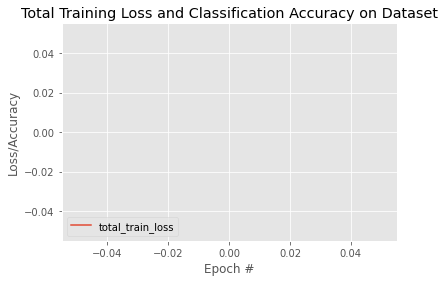

In [24]:
plt.style.use("ggplot")
plt.figure()
plt.plot(H["total_train_loss"], label="total_train_loss")
# plt.plot(H["train_class_acc"], label="train_class_acc")
plt.title("Total Training Loss and Classification Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

In [25]:
objectDetector.eval()

ObjectDetector(
  (baseModel): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
 

In [26]:
class My_Test_Dataset(Dataset):
  def __init__(self, path, trans = None):
    self.path = path
    self.df = pd.read_csv(f'{path}test.csv')
    self.trans = trans


  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
#     im = iio.imread(f"{self.path}/images/{self.df.iloc[idx,1]}")
    im_path = self.df.iloc[idx,0]
    im = iio.v2.imread(f"{self.path}/images/{im_path}")

    if self.trans:
      im = self.trans(im)

    return (im, im_path)

In [27]:
testDataset = My_Test_Dataset("/kaggle/input/smartathondataset/dataset/", transforms.ToTensor())

In [28]:
test_loader = DataLoader(testDataset, batch_size = batch_size, shuffle = False)

In [29]:
tl = iter(test_loader)
test_batch = next(tl)
test_batch[0].shape

torch.Size([16, 3, 1080, 1920])

In [30]:
xmaxPreds = []
xminPreds = []

ymaxPreds = []
yminPreds = []

imagesPath = []
labelsPreds = []

with torch.no_grad():
  # dont keep track of the gradients (hence it is much faster, whenever possible => use it)
  for images, image_path in test_loader:
        
    images = images.to(device)
    xmax_hat, xmin_hat, ymax_hat, ymin_hat, labels_hat = objectDetector(images)
    
    # example: [0.1, 0.05, 0.02, 0.8] => we use argmax
    # do the armmax on the columns not on the batch size (batch size is axis 0)
    labels_yhat = torch.argmax(labels_hat, axis = 1)  # finding the label
    
    xmaxPreds.extend(xmax_hat.detach().cpu().numpy())
    xminPreds.extend(xmin_hat.detach().cpu().numpy())
    
    ymaxPreds.extend(ymax_hat.detach().cpu().numpy())
    yminPreds.extend(ymin_hat.detach().cpu().numpy())
    
    imagesPath.extend(list(image_path))
    labelsPreds.extend(labels_yhat.detach().cpu().numpy())

In [31]:
xmaxPreds = np.array(xmaxPreds) * WIDTH
xminPreds = np.array(xminPreds) * WIDTH

ymaxPreds = np.array(ymaxPreds) * HEIGHT
yminPreds = np.array(yminPreds) * HEIGHT

In [32]:
classNameDict = batch[7]

# print(classNameDict)

names = [classNameDict[i][0] for i in labelsPreds]

In [33]:
data = {'class' : labelsPreds,
       'image_path' : imagesPath,
        'name' : names,
       'xmax' : xmaxPreds,
       'xmin' : xminPreds,
       'ymax' : ymaxPreds,
       'ymin' : yminPreds}

In [34]:
df = pd.DataFrame(data)
df

,class,image_path,name,xmax,xmin,ymax,ymin
0,9,953ab1447c46ecfef67ab14629cd70c7.jpg,CLUTTER_SIDEWALK,933.301575,931.889832,524.827881,524.809937
1,3,e4ddbaa7970fca225a51288ce5f7d3f9.jpg,GARBAGE,925.578857,922.336487,520.360352,519.937866
2,2,5b8120d69607a077b7583334be3ba18b.jpg,POTHOLES,919.865540,928.685242,518.801453,519.294250
3,3,138b1dc82005b4c33e4886260649d313.jpg,GARBAGE,938.409180,945.603882,528.795044,529.679565
4,3,0f91ec1533b845b13089f8cf4e0a36f7.jpg,GARBAGE,932.452393,933.596680,524.231567,524.129761
...,...,...,...,...,...,...,...
2087,3,3e7dd159466f14474a0173e9b02f512a.jpg,GARBAGE,935.940369,941.811157,526.275085,527.264526
2088,3,a464d4600589ddf541bed59942c0228d.jpg,GARBAGE,932.454956,933.143921,525.305603,525.048462
2089,3,0a490958aac3c79bb815a0f1f6825284.jpg,GARBAGE,923.340149,925.329407,521.322998,520.970642
2090,3,15afe8bce6c71deed2d53f56b78b90a8.jpg,GARBAGE,925.935791,921.111023,516.222351,517.125488


In [35]:
df.to_csv('submission.csv', index = False)

In [36]:
class My_Predicted_Dataset(Dataset):
  def __init__(self, path, trans = None):
    self.path = path
    self.df = pd.read_csv(f'/kaggle/working/submission.csv')
#     display(self.df)
    self.trans = trans


  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
#     im = iio.imread(f"{self.path}/images/{self.df.iloc[idx,1]}")
    im = iio.v2.imread(f"{self.path}/images/{self.df.iloc[idx,1]}")

    # print(im.shape)
    
    # Class & Label Dictionary
    
    #self.df['class'] = self.df['class']#.astype('int32')
    
    label = self.df.iloc[idx,2]
    
    xmax = self.df.iloc[idx,3]
    xmin = self.df.iloc[idx,4]
    ymax = self.df.iloc[idx,5]
    ymin = self.df.iloc[idx,6]
    
    # bbox = np.array([xmax, xmin, ymax, ymin])
    
    if self.trans:
      im = self.trans(im)

    return (im, xmax, xmin, ymax, ymin, label)

In [37]:
predictedDataset = My_Predicted_Dataset("/kaggle/input/smartathondataset/dataset/", transforms.ToTensor())

In [38]:
pred_loader = DataLoader(predictedDataset, batch_size = batch_size, shuffle = True)

In [39]:
tl = iter(pred_loader)
pred_batch = next(tl)
pred_batch[0].shape

torch.Size([16, 3, 1080, 1920])

In [40]:
xmax = pred_batch[1]
xmin = pred_batch[2]

ymax = pred_batch[3]
ymin = pred_batch[4]

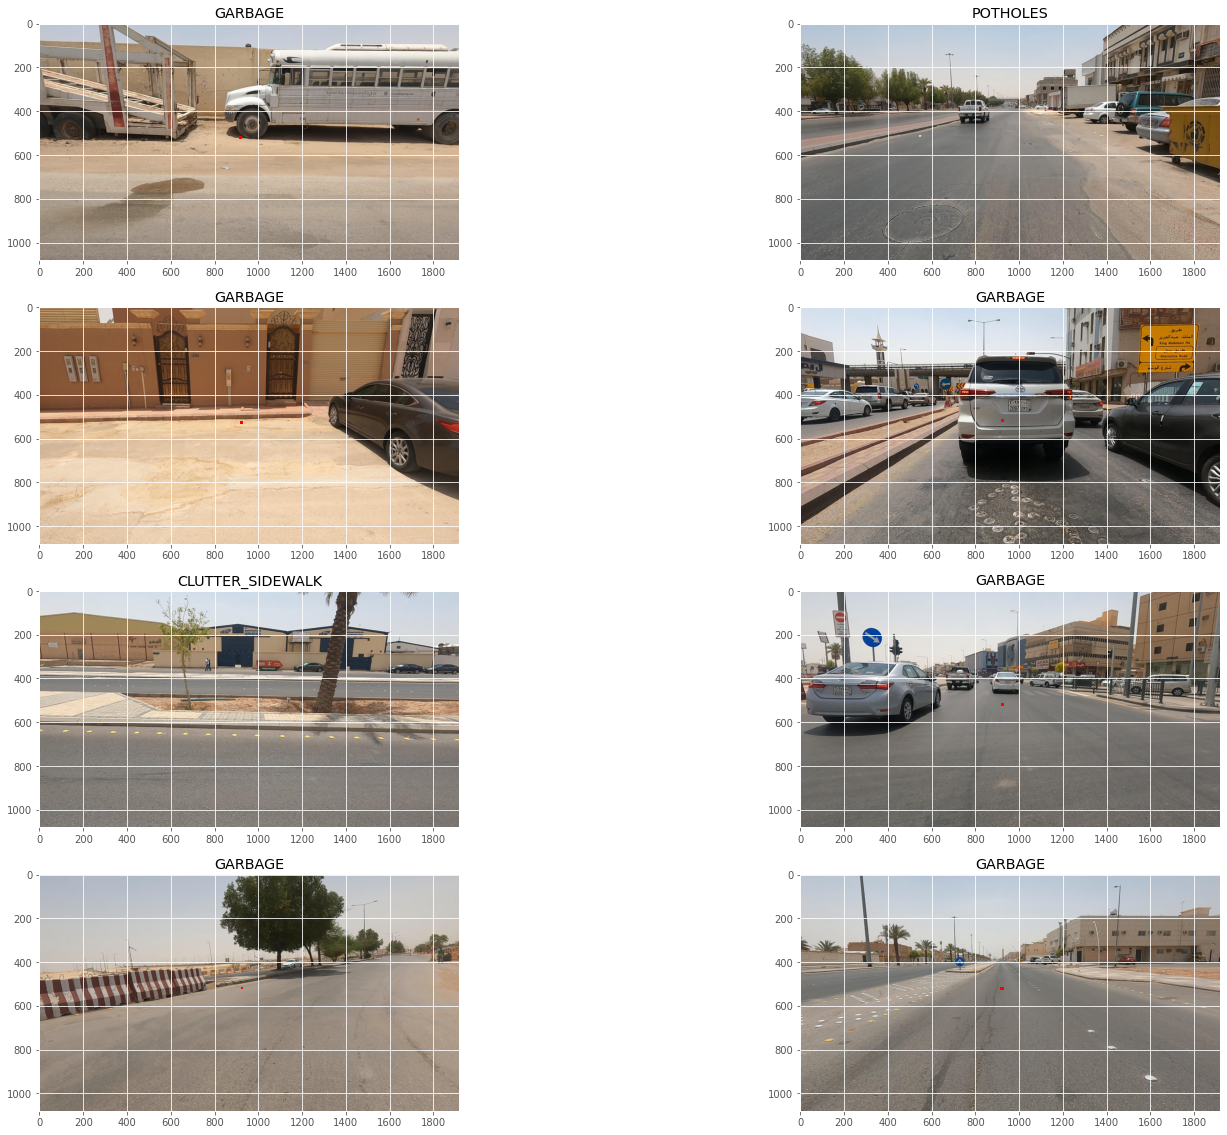

In [41]:
k = 1
plt.figure(figsize=(25,20))
for i in range(8):
    plt.subplot(4,2,k)
    img = pred_batch[0][k-1,:,:,:]
    plt.gca().add_patch(Rectangle((xmin[k-1],ymin[k-1]),xmax[k-1]-xmin[k-1],ymax[k-1]-ymin[k-1],
                    edgecolor='red',
                    facecolor='none',
                    lw=2))
    plt.xticks(np.arange(0, 1920, 200))
    plt.imshow(np.transpose(img, (1,2,0)))
    plt.title(pred_batch[5][k-1])
    k+=1